<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/Customized_Callback_with_real_time_ploting_and_learning_rate_rescheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLaB with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n>>>>please load your drive")
def time_fmt(t:float = 123.810)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
print(f">>>>testing:\tplease wait...\ntime elapse:\t{time_fmt()}")


Mounted at /content/drive
You are on CoLaB with tensorflow version: 2.4.1
>>>>testing:	please wait...
time elapse:	0: 02: 03.00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, time, datetime
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback
%load_ext tensorboard
plt.style.use('fivethirtyeight')


In [3]:
#Loading and processing the data:

In [4]:
class _Get_data():

  def _load_data(self):
    (ds_train, ds_test), ds_info = tfds.load(
        name = 'mnist',
        with_info = True,
        shuffle_files = True,
        as_supervised = True,
        split = ['train', 'test']
    )
    return ds_train, ds_test, ds_info

  def _load_data_new(self):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train.reshape(-1, 28,28,1).astype(np.float32)/255.0, x_test.reshape(-1,28,28,1).astype(np.float32)/255.0
    y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)
    BUFFER, BATCH_SIZE = len(x_train), 64
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)
    test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_data = test_data.batch(BATCH_SIZE, drop_remainder = True)
    return train_data, test_data

  def _display_summary(self):
    ds_train,_,ds_info = self._load_data()
    print(ds_info)
    fig = tfds.show_examples(ds_train, ds_info, rows = 5, cols = 5)
    print(fig)
  
  def _preprocess_data(self,image, label):
    return tf.cast(image, tf.float32)/255.0, label
  
  def _data_aug_(self, image, label):
    image = tf.image.random_brightness(image, max_delta = 0.1)
    image = tf.image.random_flip_left_right(image)
    return image, label
  
  def _train_validation_data(self):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = 128
    train_ds, test_ds, ds_info = self._load_data()
    train_data = train_ds.map(self._preprocess_data, num_parallel_calls = AUTOTUNE)
    train_data = train_data.cache()
    train_data = train_data.shuffle(ds_info.splits['train'].num_examples)
    train_data = train_data.map(self._data_aug_)
    train_data = train_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)
    train_data = train_data.prefetch(AUTOTUNE)
    test_data = test_ds.map(self._preprocess_data, num_parallel_calls = AUTOTUNE)
    test_data = test_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)
    return train_data, test_data


In [5]:
data_class = _Get_data()

In [6]:
train_data, test_data = data_class._load_data_new()

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
x_batch, y_batch = next(iter(train_data))
x_batch.shape, y_batch.shape

(TensorShape([64, 28, 28, 1]), TensorShape([64, 10]))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



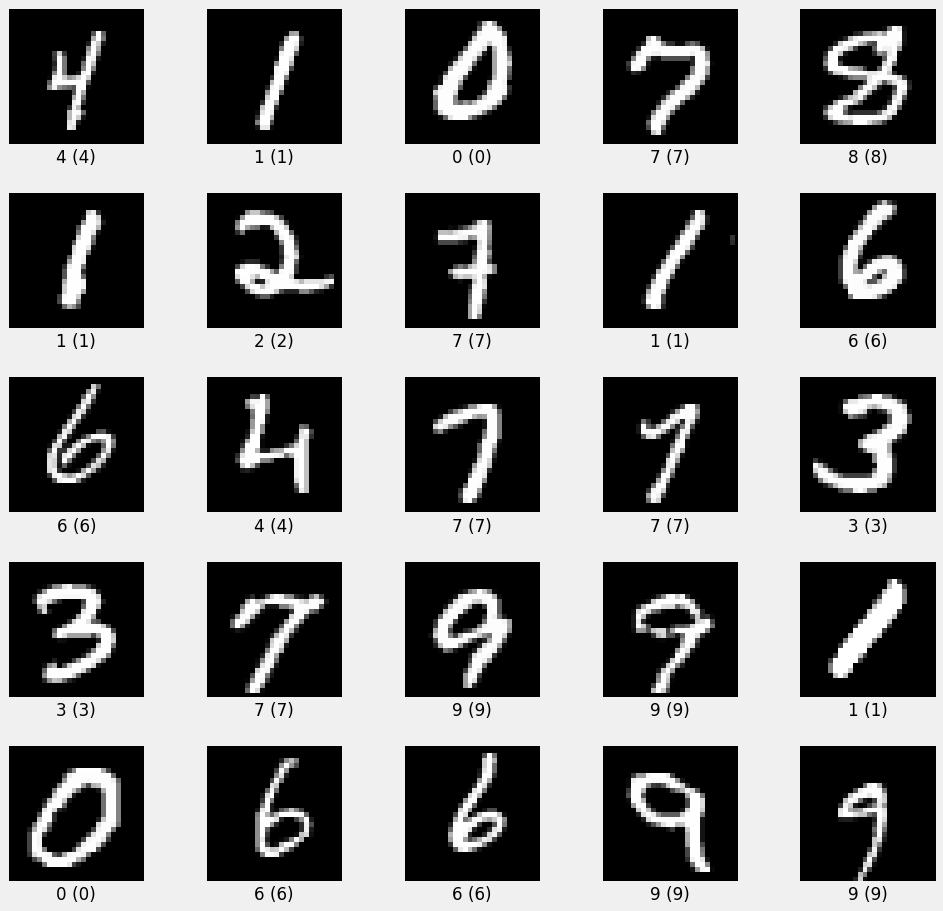

Figure(1080x1080)


In [8]:
my_summary = data_class._display_summary()

In [9]:
#Building the simple residual network:

In [10]:
class CNNBLOCK(tf.keras.layers.Layer):
  
  def __init__(self, num_filters, kernel = 3, *args, **kwargs):
    super(CNNBLOCK, self).__init__(*args, **kwargs)
    self.conv = tf.keras.layers.Conv2D(filters = num_filters,
                                       kernel_size = 3, 
                                       activation = 'relu',
                                       padding = 'same')
    self.bn = tf.keras.layers.BatchNormalization()
  
  def call(self, inputs_tensor, training = False):
    x = self.conv(inputs_tensor, training = training)
    x = self.bn(x)
    return x

class ResBlock(tf.keras.layers.Layer):

  def __init__(self, num_filters, *args, **kwargs):
    super(ResBlock, self).__init__(*args, **kwargs)
    self.resblock_1 = CNNBLOCK(num_filters[0])
    self.resblock_2 = CNNBLOCK(num_filters[1])
    self.resblock_3 = CNNBLOCK(num_filters[2])
    self.max_pool = tf.keras.layers.MaxPooling2D()
    self.id_map = tf.keras.layers.Conv2D(filters = num_filters[1],
                                         kernel_size = 3,
                                         padding = 'same',
                                         activation = 'relu')
  
  def call(self, inputs_tensor, training = False):
    x = self.resblock_1(inputs_tensor, training = training)
    x = self.resblock_2(x, training = training)
    x = self.resblock_3(x + self.id_map(inputs_tensor), training = training)
    x = self.max_pool(x)
    return x

class SimpleResModel(tf.keras.Model):
  def __init__(self, num_classes = 10, *args, **kwargs):
    super(SimpleResModel, self).__init__(*args, **kwargs)
    self.block_1 = ResBlock(num_filters = [32,64,128], name = 'block_1')
    self.block_2 = ResBlock(num_filters = [64, 128,256], name = 'block_2')
    self.block_3 = ResBlock(num_filters = [128, 256, 256], name = 'block_3')
    self.flt = tf.keras.layers.Flatten()
    self.dense_1 = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'random_normal', name = 'dense_1')
    self.dense_2 = tf.keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal', name = 'dense_2')
    self.outputs = tf.keras.layers.Dense(units = num_classes, name = 'outputs')
  
  def call(self, inputs_tensor, training = False):
    x = self.block_1(inputs_tensor, training = training)
    x = self.block_2(x, training = training)
    x = self.block_3(x, training = training)
    x = self.flt(x)
    x = self.dense_1(x, training = training)
    x = self.dense_2(x, training = training)
    x = self.outputs(x, training = training)
    return x



In [11]:
#Get the model by instantiating the model class above:
model = SimpleResModel()

In [12]:
#Defining the custom callback:

In [17]:
class TrainingCallback(Callback):
  def on_train_begin(self, logs = None):
    print(f"The bigining of the training.....")
  def on_epoch_begin(self, epoch, logs = None):
    print(f"The begining of epoch: {epoch + 1}")
  def on_train_batch_begin(self, batch, logs = None):
    print(f"Training start for batch: {batch}")
  def on_train_batch_end(self, batch, logs = None):
    print(f"Training end for batch: {batch}, Loss: {logs['loss']}")
  def on_epoch_end(self, epoch, logs = None):
    print(f"Training end at epoch {epoch + 1}, Loss: {logs['loss']}, Accuracy: {logs['categorical_accuracy']}")
  def on_train_end(self, logs = None):
    print(f"The model has finished training")

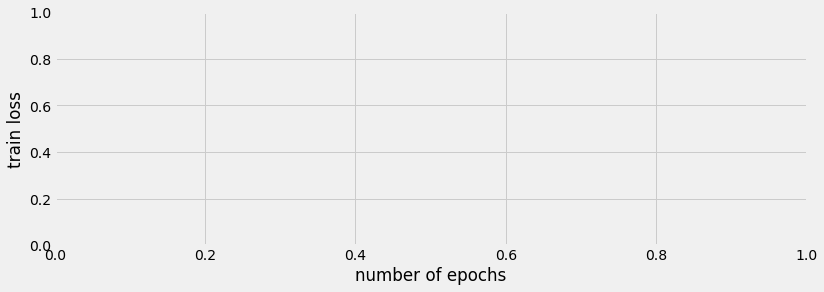

In [25]:
fig= plt.figure(figsize = (12,4))
ax = fig.add_subplot()
ax.set_xlabel('number of epochs')
ax.set_ylabel('train loss')
class TrainingPlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs['loss'])
        epochs = np.arange(0, len(self.losses))
        ax.plot(epochs, self.losses, "b-")
        fig.canvas.draw()



In [26]:
#Compiling and train the model:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = tf.keras.metrics.CategoricalAccuracy())

In [29]:
%matplotlib inline
tic = time.time()

history = model.fit(
    train_data,epochs = 3, validation_data = test_data, verbose = 2, callbacks = [TrainingPlot()]
)
toc = time.time()
print(f"training duration is :\n>>>>training time: {time_fmt(toc - tic)}")

Epoch 1/3
937/937 - 16s - loss: 0.0047 - categorical_accuracy: 0.9987 - val_loss: 0.0334 - val_categorical_accuracy: 0.9928
Epoch 2/3
937/937 - 15s - loss: 0.0096 - categorical_accuracy: 0.9976 - val_loss: 0.1945 - val_categorical_accuracy: 0.9908
Epoch 3/3
937/937 - 15s - loss: 0.0062 - categorical_accuracy: 0.9982 - val_loss: 0.0241 - val_categorical_accuracy: 0.9950
training duration is :
>>>>training time: 0: 00: 47.00
